# <center> Обучение с учителем. Классификация
## <center> Отток клиентов банка

In [17]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model #л инейные модели
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Описание задачи

Вы уже знакомились с этой задачей в модуле по визуализации и провели небольшое исследование данных.
 
В этом модуле мы построим классификатор, который позволит своевременно определять уходящих клиентов банка.

**Знакомство с данными**

Набор данных вы можете скачать по [ссылке](https://lms.skillfactory.ru/assets/courseware/v1/c903ecd0b0c995c44213d620ab6ae94d/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/churn.zip).

In [19]:
data = pd.read_csv('data/churn.zip')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Признаки:
* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которые приобрёл клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

In [20]:
TARGET_FEATURE = 'Exited'

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [22]:
# По id проверяю, что нет дубликатов клиентов в таблице
data['CustomerId'].nunique() == data.shape[0]

True

В модуле по визуализации мы выяснили, что отток клиентов в Германии, Франции и Испании имеет различные показатели. 

Исследователи, которые уже работали с этим датасетом, пришли к выводу, 

что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. 

Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [23]:
churn_data = data[data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

In [24]:
# Удаляю неинформативные признаки
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [25]:
# Проверка наличия пропуска в данных
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
* TenureByAge — отношение времени пользования банком к возрасту клиента;
* CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [26]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

In [27]:
# Перкодирую признак пола в бинарный
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [28]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 7 to 9998
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   int64  
 1   Gender               2509 non-null   int64  
 2   Age                  2509 non-null   int64  
 3   Tenure               2509 non-null   int64  
 4   Balance              2509 non-null   float64
 5   NumOfProducts        2509 non-null   int64  
 6   HasCrCard            2509 non-null   int64  
 7   IsActiveMember       2509 non-null   int64  
 8   EstimatedSalary      2509 non-null   float64
 9   Exited               2509 non-null   int64  
 10  BalanceSalaryRatio   2509 non-null   float64
 11  TenureByAge          2509 non-null   float64
 12  CreditScoreGivenAge  2509 non-null   float64
dtypes: float64(5), int64(8)
memory usage: 274.4 KB


In [29]:
data[['Balance', 'EstimatedSalary']].describe()

,Balance,EstimatedSalary
count,10000.000000,10000.000000
mean,76485.889288,100090.239881
std,62397.405202,57510.492818
min,0.000000,11.580000
25%,0.000000,51002.110000
50%,97198.540000,100193.915000
75%,127644.240000,149388.247500
max,250898.090000,199992.480000


На второй итерации попробую округлить данные признаки и привести их к целому типу.

Нет смысла в излишней точности.

In [30]:
data['Balance'] = data['Balance'].round().astype('int')
data['EstimatedSalary'] = data['EstimatedSalary'].round().astype('int')

In [31]:
# Разделим набор данных на матрицу наблюдений X и столбец ответов y
X = churn_data.drop(TARGET_FEATURE, axis=1)
y = churn_data[TARGET_FEATURE]

In [32]:
# Нормализую признаки
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

Проверка сбалансированности классов

In [33]:
y.value_counts(True) * 100

0    67.556796
1    32.443204
Name: Exited, dtype: float64

Очевидно, что наши классы не сбалансированы. Ушедших пользователей — 32 %, в то время как лояльных — 68 %. 

При разделении нашего набора данных на тренировочный и тестовый может возникнуть такая ситуация, 

что в тренировочную выборку попадут только лояльные клиенты или их большая часть. 

Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет оставлять желать лучшего.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. 

Тогда модель будет показывать прекрасное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. 
Такое разбиение выборки называется стратифицированным. 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [35]:
print('TRAIN')
print((y_train.value_counts(True) * 100).round())

print('TEST')
print((y_test.value_counts(True) * 100).round())

TRAIN
0    68.0
1    32.0
Name: Exited, dtype: float64
TEST
0    68.0
1    32.0
Name: Exited, dtype: float64


Благодаря stratify разбиение происходит ровно в той же пропорции классов что и во всей выборке

In [36]:
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


### Задание 4.1
Для начала давайте заранее определим метрику, на которую будем ориентироваться.

По условию задачи наша модель должна своевременно предсказывать отток клиентов. 

Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра, 

а для клиентов, у которых вероятность оттока наиболее высока, — специальные предложения. 

Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому ложные срабатывания желательно минимизировать. 

Однако в то же время необходимо сохранить как можно больше клиентов.

Какую метрику в данной задаче вы будете пытаться улучшить?

### В данной задаче нам нужен баланс между presicion и recall, поэтому мы будем использовать F1-меру.

### Задание 4.2
Обучите модель логистической регрессии на тренировочных данных. 

Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. 

В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. 

Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках? 

Ответ приведите с точностью до двух знаков после точки-разделителя.

In [37]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', # алгоритм оптимизации
    random_state=42
)

In [38]:
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='sag')

In [39]:
y_train_predict = log_reg.predict(X_train)
y_test_predict = log_reg.predict(X_test)

In [40]:
print('TRAIN:')
print(f'{metrics.f1_score(y_train, y_train_predict):.2f}')
print()
print('TEST:')
print(f'{metrics.f1_score(y_test, y_test_predict):.2f}')

TRAIN:
0.49

TEST:
0.47


### Задание 4.3
Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. 

Используйте класс PolynomialFeatures из библиотеки sklearn. 

Параметр include_bias выставите в значение False.

In [41]:
poly_features = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

In [42]:
poly_features.fit(X_scaled)

PolynomialFeatures(degree=3, include_bias=False)

In [43]:
X_scaled_poly = poly_features.transform(X_scaled)

In [44]:
print(X_scaled.shape)
print(X_scaled_poly.shape)

(2509, 12)
(2509, 454)


### Задание 4.4
Обучите модель логистической регрессии на полиномиальных признаках.

Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. 

Параметру random_state выставите значение 42 для воспроизводимости результатов. 

Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.

Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках для модели,

обученной на полиномиальных признаках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_poly, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 454)
Test shape: (628, 454)


In [46]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', # алгоритм оптимизации
    random_state=42,
    max_iter=1000
)

In [47]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [48]:
y_train_predict = log_reg.predict(X_train)
y_test_predict = log_reg.predict(X_test)

In [49]:
print('TRAIN:')
print(f'{metrics.f1_score(y_train, y_train_predict):.2f}')
print()
print('TEST:')
print(f'{metrics.f1_score(y_test, y_test_predict):.2f}')

TRAIN:
0.66

TEST:
0.64


### Задание 4.5
Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. 

Используйте логистическую регрессию, обученную на полиномиальных признаках из предыдущего задания.

В качестве порога вероятности используйте значения из следующего диапазона:

In [50]:
thresholds = np.arange(0.1, 1, 0.05)

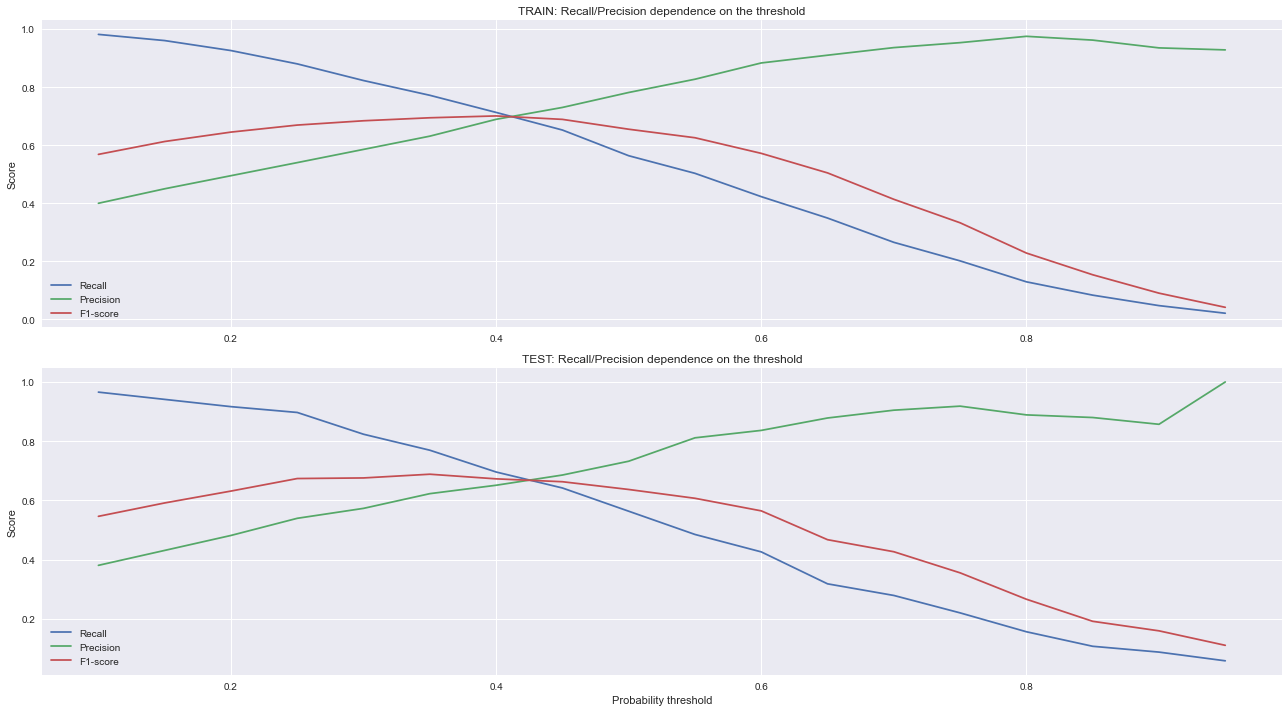

In [51]:
# Считаем вероятности наличия диабета для каждого из пациентов
# Нас интересует только вероятность класса (второй столбец)
y_train_proba_pred = log_reg.predict_proba(X_train)[:, 1]
y_test_proba_pred = log_reg.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_train_proba_pred = pd.Series(y_train_proba_pred)
y_test_proba_pred = pd.Series(y_test_proba_pred)

# Создадим списки, в которых будем хранить значения метрик 
recall_scores_train = []
precision_scores_train = []
f1_scores_train = []

recall_scores_test = []
precision_scores_test = []
f1_scores_test = []

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_train_pred = y_train_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    recall_scores_train.append(metrics.recall_score(y_train, y_train_pred))
    precision_scores_train.append(metrics.precision_score(y_train, y_train_pred))
    f1_scores_train.append(metrics.f1_score(y_train, y_train_pred))
    
    recall_scores_test.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores_test.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores_test.append(metrics.f1_score(y_test, y_test_pred))

# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(2, 1, figsize=(18, 10)) # фигура + координатная плоскость

# Строим линейный график зависимости recall от threshold
ax[0].plot(thresholds, recall_scores_train, label='Recall')

# Строим линейный график зависимости precision от threshold
ax[0].plot(thresholds, precision_scores_train, label='Precision')

# Строим линейный график зависимости F1 от threshold
ax[0].plot(thresholds, f1_scores_train, label='F1-score')

# Даем графику название и подписи осям
ax[0].set_title('TRAIN: Recall/Precision dependence on the threshold')
# ax[0].set_xlabel('Probability threshold')
ax[0].set_ylabel('Score')
ax[0].legend()

# Строим линейный график зависимости recall от threshold
ax[1].plot(thresholds, recall_scores_test, label='Recall')

# Строим линейный график зависимости precision от threshold
ax[1].plot(thresholds, precision_scores_test, label='Precision')

# Строим линейный график зависимости F1 от threshold
ax[1].plot(thresholds, f1_scores_test, label='F1-score')

# Даем графику название и подписи осям
ax[1].set_title('TEST: Recall/Precision dependence on the threshold')
ax[1].set_xlabel('Probability threshold')
ax[1].set_ylabel('Score')
ax[1].legend()

plt.tight_layout()
plt.show()

In [52]:
# Задаем оптимальный порог вероятностей
threshold_opt = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628

